In [74]:
import pandas as pd

Source: https://www.analyticsvidhya.com/blog/2021/06/rule-based-sentiment-analysis-in-python/

In [75]:
df1 = pd.read_csv('data_with_city.csv').iloc[:,4:]

In [76]:
df1.sample(5)

,Datetime,Tweet Id,Text,Username,Hashtags,Like(s),Reply(s),Retweet(s),Search term,Coordinates,Latitude,Longitude,city,country
2385,2022-03-03 14:49:58+00:00,1499396669451890695,@BBCWorld Do one putin u sad man natio waiting...,Matthew70449943,NaN,0,0,0,Russia,"Coordinates(longitude=-0.18576, latitude=51.60...",51.604519,-0.185760,Hendon,GB
796,2022-02-25 14:28:44+00:00,1497217001336487966,@MaxtheDoggogam1 The rest of Russia (and its e...,VilleJansson,NaN,1,1,0,Russia,"Coordinates(longitude=24.78281, latitude=60.02...",60.021032,24.782810,Koukkuniemi,FI
11575,2022-03-04 11:37:15+00:00,1499710561877168130,.@NATO how many pleading do you need to #Close...,anna_maksymova,"['CloseTheSky', 'ClosetheSkyoverUkraine']",0,0,0,NATO,"Coordinates(longitude=2.2241006, latitude=48.8...",48.815521,2.224101,Sevres,FR
1207,2022-02-27 12:13:30+00:00,1497907743533191172,#UkraineRussiaWar \noh my godness! This is so ...,Bruce_Zengggg,['UkraineRussiaWar'],3,0,0,Russia,"Coordinates(longitude=121.457132, latitude=24....",24.960508,121.457132,Banqiao,TW
11075,2022-02-25 15:53:32+00:00,1497238340889980928,@alexstubb @NATO Falling into a trap of trying...,RobertBlaszczak,NaN,0,0,0,NATO,"Coordinates(longitude=-0.112442, latitude=51.5...",51.506800,-0.112442,City of Westminster,GB


## 0.preprocess

In [4]:
import re
import nltk
def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text
df1['cleaned'] = df1['Text'].apply(clean)
from tqdm.notebook import tqdm
tqdm.pandas()

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

df1['tagged'] = df1['cleaned'].progress_apply(token_stop_pos)

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df1['lemma'] = df1['tagged'].progress_apply(lemmatize)

[nltk_data] Downloading package punkt to /Users/zhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/zhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zhang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 1. Use Textblob

In [4]:
from textblob import TextBlob

$subjectivity \in [0:1]: 0=neutral, 1=opinioned$ <br/>
$polarity \in [-1:1]: -1=negative, 1=positive$

In [5]:
df1['textblob_subjectivity'] = df1['Text'].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
df1['textblob_polarity'] = df1['Text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 2. Use VADER

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [7]:
df1['vader_pos'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['pos'])
df1['vader_neu'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['neu'])
df1['vader_neg'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['neg'])
df1['vader_polarity'] = df1['Text'].progress_apply(lambda x:analyzer.polarity_scores(x)['compound'])

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

## 3. Use SentiWordNet

In [8]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import sentiwordnet as swn

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/zhang/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
def sentiwordnetanalysis(pos_data):
    pos_score,neg_score=0,0
    total_tokens = 0
    for word, pos in pos_data:
        if not pos:
            continue
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        if not lemma:
            continue
        synsets = wordnet.synsets(lemma, pos=pos)
        if not synsets:
            continue
        total_tokens+=1
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        pos_score+= swn_synset.pos_score()
        neg_score+= swn_synset.neg_score()
    if total_tokens==0:
        return 0,0
    return pos_score/total_tokens,neg_score/total_tokens


In [10]:
df1['swn_pos'] = df1['tagged'].progress_apply(lambda x: sentiwordnetanalysis(x)[0])
df1['swn_neg'] = df1['tagged'].progress_apply(lambda x: sentiwordnetanalysis(x)[1])
df1['swn'] = df1['swn_pos']-df1['swn_neg']

  0%|          | 0/12181 [00:00<?, ?it/s]

  0%|          | 0/12181 [00:00<?, ?it/s]

In [11]:
df1.sample(5)

,Datetime,Tweet Id,Text,Username,Hashtags,Like(s),Reply(s),Retweet(s),Search term,Coordinates,...,lemma,textblob_subjectivity,textblob_polarity,vader_pos,vader_neu,vader_neg,vader_polarity,swn_pos,swn_neg,swn
6185,2022-02-26 12:55:25+00:00,1497555903964655621,Back at my parents' place for dinner. Arguing ...,ElvinOngPolSci,NaN,11,0,0,Ukraine,"Coordinates(longitude=103.89216999988, latitud...",...,Back parent place dinner Arguing father Russ...,0.160000,0.120000,0.181,0.598,0.221,-0.0258,0.017857,0.000000,0.017857
858,2022-02-26 14:47:37+00:00,1497584139612086274,@PrezzVerde Anything possible but targets Russ...,tanveerjk1,NaN,0,0,0,Russia,"Coordinates(longitude=36.8878157, latitude=55....",...,PrezzVerde Anything possible target Russia w...,0.341667,0.008333,0.000,1.000,0.000,0.0000,0.162500,0.037500,0.125000
6728,2022-02-27 14:36:00+00:00,1497943604710543360,The collect for the Ukraine in frankfurter all...,DamsTweets,NaN,7,1,1,Ukraine,"Coordinates(longitude=13.088304, latitude=52.3...",...,collect Ukraine frankfurter allee already fu...,0.550000,0.350000,0.000,1.000,0.000,0.0000,0.034091,0.000000,0.034091
4089,2022-03-11 15:41:48+00:00,1502308819023671305,😡😡😡😡😡😡\nAnother war crime.....\n#StandWithUkra...,mecki511,"['StandWithUkraine', 'Russia', 'StopRussia', '...",0,0,0,Russia,"Coordinates(longitude=13.088304, latitude=52.3...",...,Another war crime StandWithUkraine Russia St...,0.000000,0.000000,0.000,0.748,0.252,-0.8126,0.000000,0.000000,0.000000
4742,2022-03-14 21:45:17+00:00,1503487457400176650,@mfa_russia @RussianEmbassy Would you like to ...,marcel11252,"['FckPutin', 'StopRussianAggression']",0,0,0,Russia,"Coordinates(longitude=-0.2925791, latitude=51....",...,mfa russia RussianEmbassy Would like comment...,0.600000,0.125000,0.215,0.500,0.285,-0.5827,0.086538,0.057692,0.028846


In [44]:
df1.to_csv('df1.csv')

## 4. Some Visualizations

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

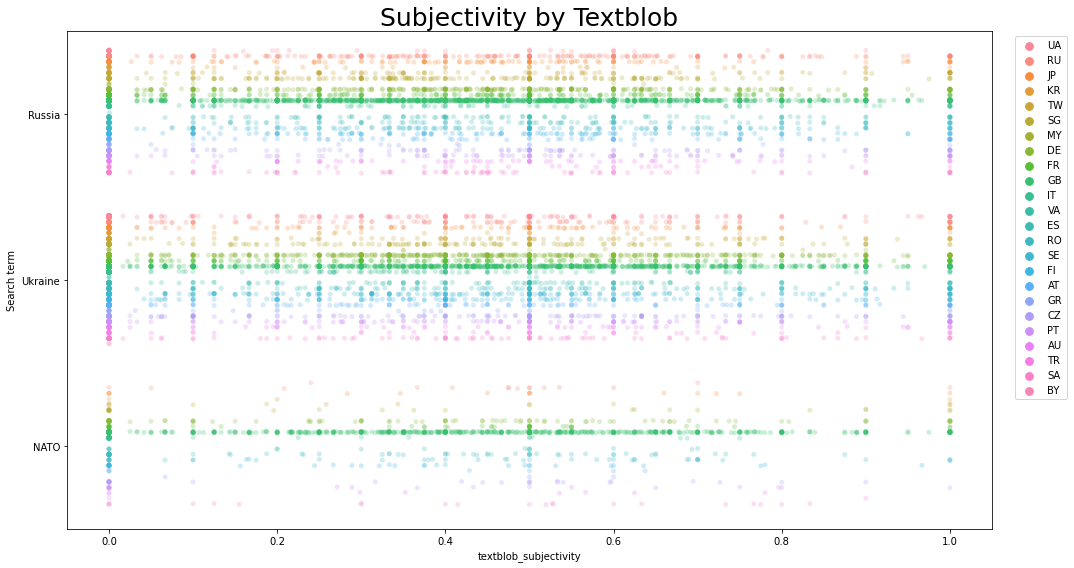

In [13]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="textblob_subjectivity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Subjectivity by Textblob',size=25)
plt.tight_layout()
plt.show()

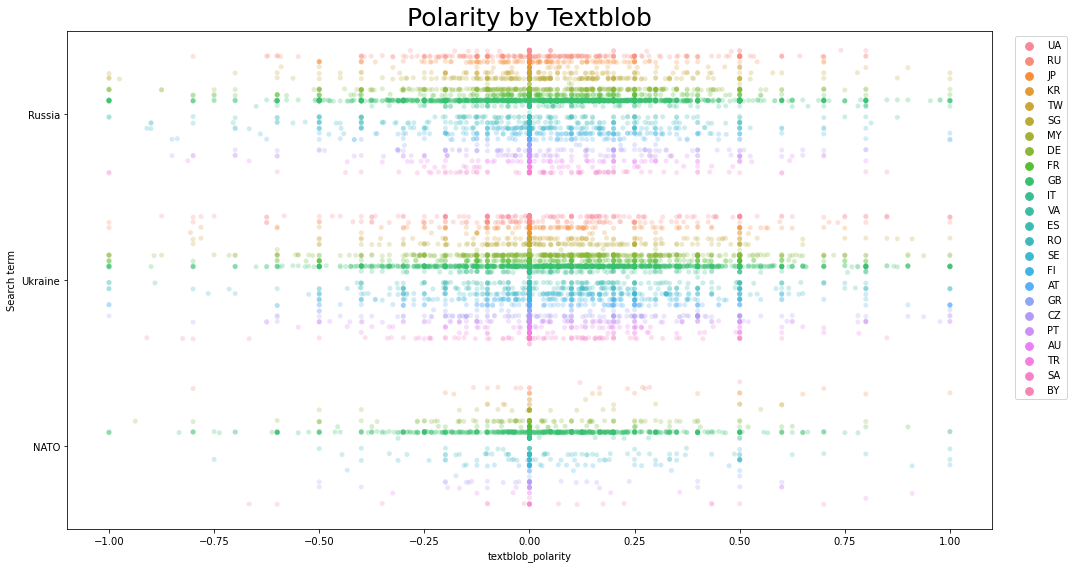

In [14]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="textblob_polarity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by Textblob',size=25)
plt.tight_layout()
plt.show()

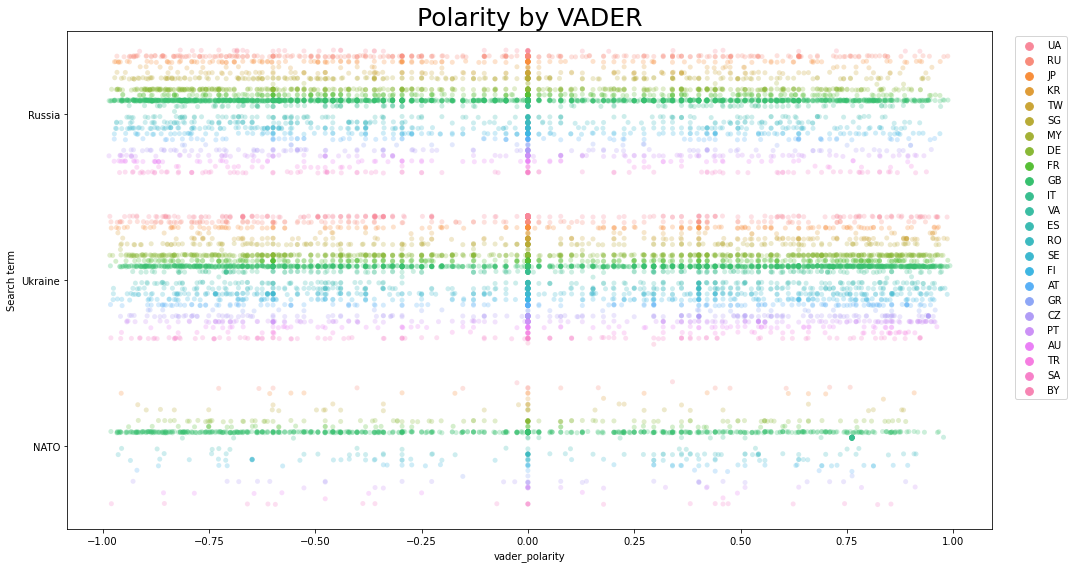

In [15]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="vader_polarity", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by VADER',size=25)
plt.tight_layout()
plt.show()

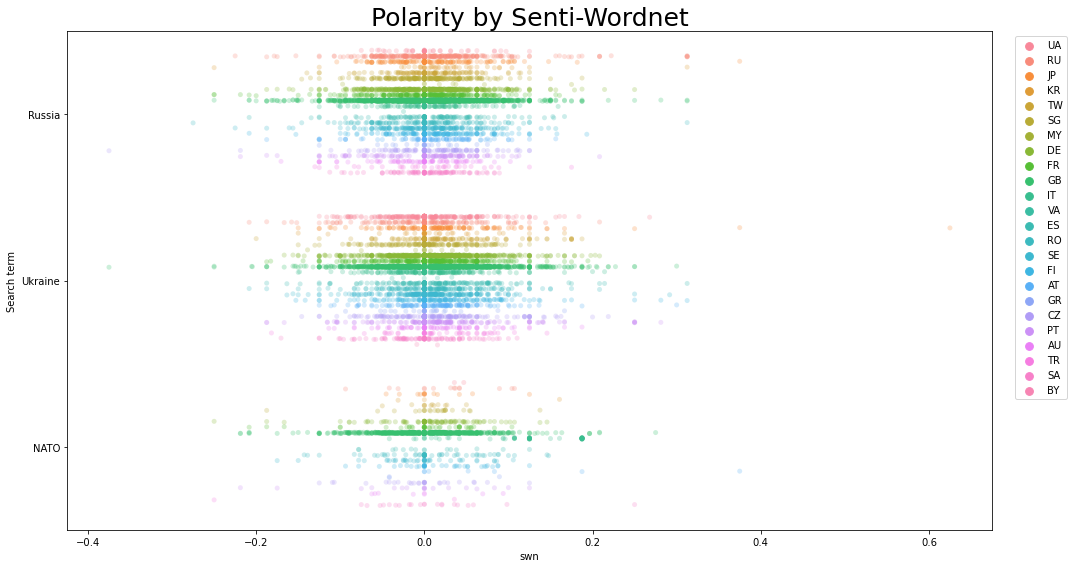

In [16]:
plt.figure(figsize=(15,8))
sns.despine(bottom=True, left=True)
sns.stripplot(x="swn", y="Search term", hue="country",
              data=df1, dodge=True, alpha=.25, zorder=1)
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.title('Polarity by Senti-Wordnet',size=25)
plt.tight_layout()
plt.show()

In [102]:
df1 = pd.read_csv('df1.csv')
df1.keys()

Index(['Unnamed: 0', 'Datetime', 'Tweet Id', 'Text', 'Username', 'Hashtags',
       'Like(s)', 'Reply(s)', 'Retweet(s)', 'Search term', 'Coordinates',
       'Latitude', 'Longitude', 'city', 'country', 'cleaned', 'tagged',
       'lemma', 'textblob_subjectivity', 'textblob_polarity', 'vader_pos',
       'vader_neu', 'vader_neg', 'vader_polarity', 'swn_pos', 'swn_neg',
       'swn'],
      dtype='object')

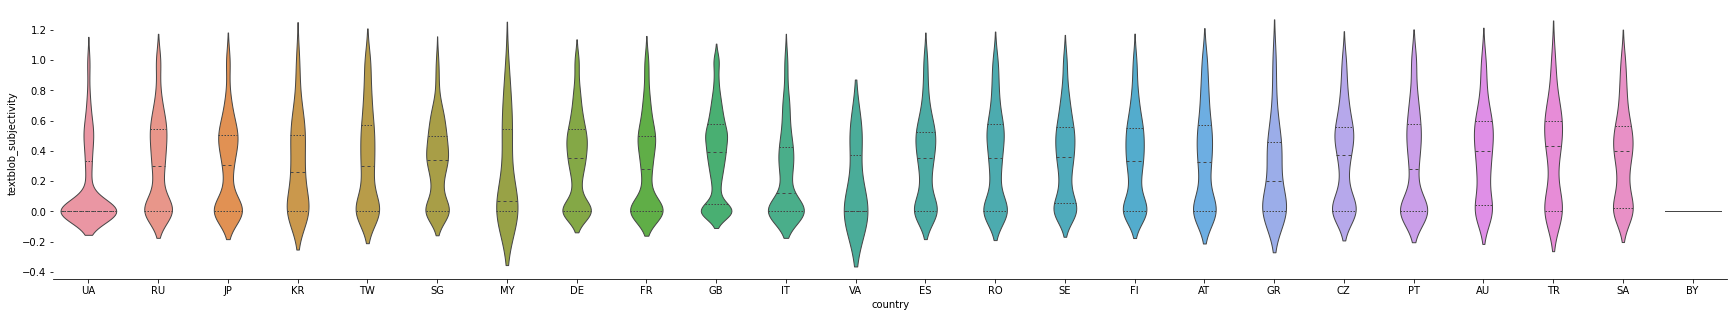

In [101]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="textblob_subjectivity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

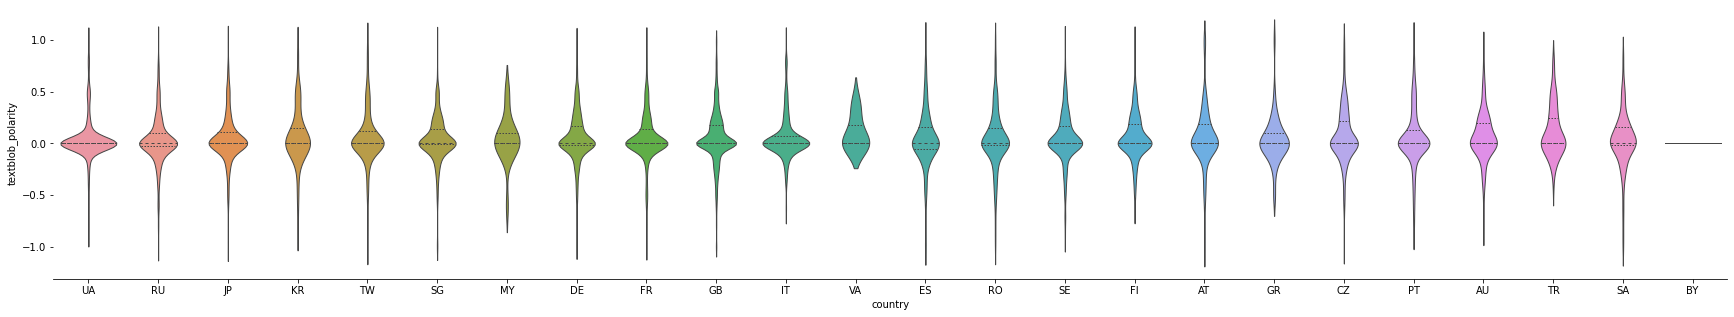

In [103]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="textblob_polarity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

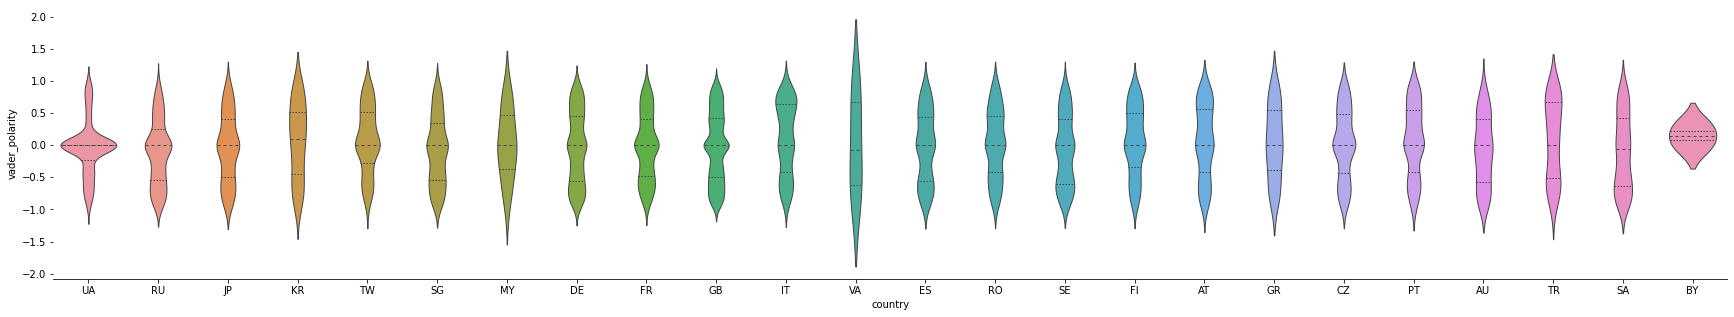

In [104]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="vader_polarity",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

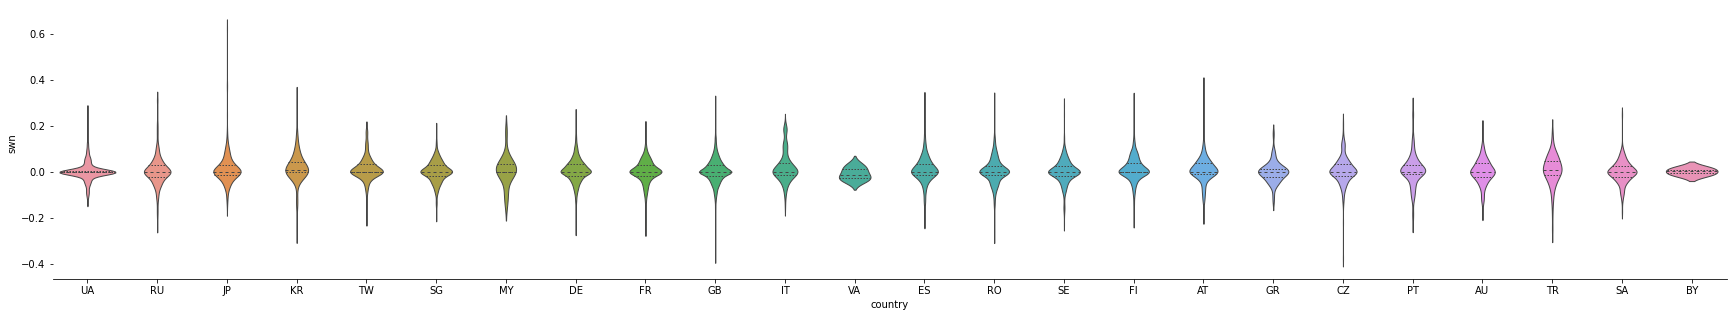

In [105]:
plt.figure(figsize=(30,5))
sns.violinplot(data=df1, x="country", y="swn",
               split=True, inner="quart", linewidth=1,
               )
sns.despine(left=True)

In [106]:
d2 = pd.DataFrame()

In [173]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').textblob_polarity.mean()
tb = dict(textblob_polarity)
l0 = [(tb[k],k) for k in tb]
l0.sort()
l0 = l0[::-1]
l0
rank_t = dict(zip([x[1] for x in l0],list(range(len(l0)))))

In [174]:
len(l0),len(l1),len(l2)

(24, 24, 24)

In [154]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').vader_polarity.mean()
tb = dict(textblob_polarity)
l1 = [(tb[k],k) for k in tb]
l1.sort()
l1 = l1[::-1]
l1
rank_v = dict(zip([x[1] for x in l1],list(range(len(l0)))))

In [155]:
from sklearn.preprocessing import StandardScaler
import numpy as np
textblob_polarity = df1.groupby('country').swn.mean()
tb = dict(textblob_polarity)
l2 = [(tb[k],k) for k in tb]
l2.sort()
l2 = l2[::-1]
l2
rank_s = dict(zip([x[1] for x in l2],list(range(len(l0)))))

In [156]:
polarity_rank = pd.DataFrame({
    'textblob':rank_t,
    'vader':rank_v,
    'swn':rank_s
})
polarity_rank

,textblob,vader,swn
TR,0,2,7
VA,1,12,23
CZ,2,9,8
AU,3,20,15
KR,4,4,1
FI,5,7,2
TW,6,3,3
AT,7,6,5
IT,8,1,0
GB,9,15,13


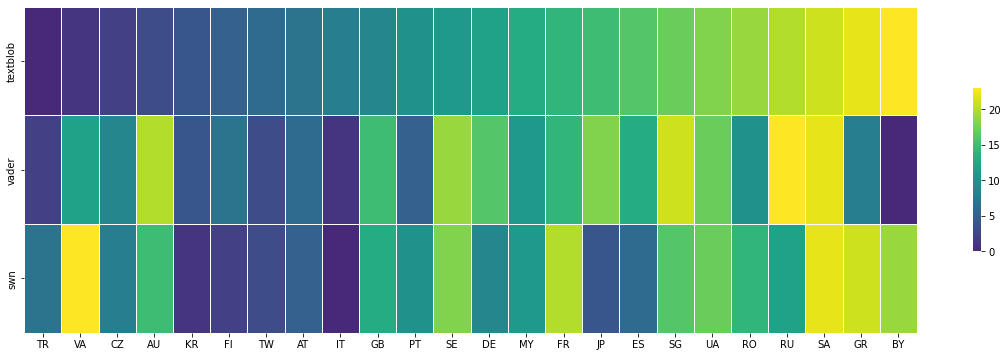

In [186]:
# Generate a custom diverging colormap
cmap = sns.color_palette("viridis", as_cmap=True)

plt.figure(figsize=(20,6))
sns.heatmap(polarity_rank.T, cmap=cmap, center=10,
            square=False, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heat.svg')